# Subset DEM and NLCD from Google Earth Engine, SSURGO from Web Soil Survey

Using the AOI shapefile generated in Step 2, we will now download elevation and land cover data (National Land Cover Database, NLCD) from Google Earth Engine's repository, again using geemap to interact with these data in the cloud.

<div class="alert alert-block alert-danger">
<b> Project Name Setting: </b> Please set the Project Name and Cell Resolution for your project </div>

In [1]:
# CHANGE PROJECT NAME HERE
PROJECT_NAME = 'Test'

# CURRENT DIRECTORY HERE, SET WHERE THE NOTEBOOKS ARE LOCATED
CURRENT_DIRECTORY = '/home/teaganbaiotto/Documents/bbgci'

# SET THE SPATIAL RESOLUTION (in meters)
SPATIAL_RESOLUTION = 30

In [2]:
import os, shutil
os.chdir(CURRENT_DIRECTORY)

In [3]:
# Define folder paths as global variables
PROJECT_DIR = os.path.join(CURRENT_DIRECTORY, PROJECT_NAME)
RAWGIS_DIR = os.path.join(PROJECT_DIR, "gis_data")
RAWOBS_DIR = os.path.join(PROJECT_DIR, "obs")
RAWSOIL_DIR = os.path.join(RAWGIS_DIR, "soil")
MODEL_DIR = os.path.join(PROJECT_DIR, 'model')
DEF_DIR = os.path.join(MODEL_DIR, 'defs')
INI_DIR = os.path.join(MODEL_DIR, 'ini_files')
EPC_DIR = os.path.join(MODEL_DIR, 'epc_files')
OUTPUT_DIR = os.path.join(MODEL_DIR, 'output')
CO2_DIR = os.path.join(MODEL_DIR, 'co2')
NDEP_DIR = os.path.join(MODEL_DIR, 'ndep')
ENDPOINT_DIR = os.path.join(MODEL_DIR, 'endpoint_files')
SPINUP_DIR = os.path.join(MODEL_DIR, 'spinup')
NORMAL_DIR = os.path.join(MODEL_DIR, 'normal')
MODEL_RAST_DIR = os.path.join(MODEL_DIR, 'raster_inputs')
IMAGE = os.path.join(PROJECT_DIR, 'image_map')

## Install geemap package

In [4]:
# Upgrade the Earth Engine API to ensure consistent performance
# !pip install earthengine-api --upgrade

# Installs geemap package
import sys, site

try:
    import geemap
except ImportError:
    # If error with this cell, try commenting out next line and un-commenting two lines below.
    !pip install -U geemap
    # !{sys.executable} -m pip install geemap==0.9.1
    sys.path.insert(0, site.getusersitepackages())

# Authenticates and initializes Earth Engine
import ee
import geemap

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()  

## Create an interactive map

In [5]:
Map = geemap.Map(center=[40,-100], zoom=4)
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

## Import AOI

Importing the AOI saved from Step 2 into the computing environment as a variable

In [6]:
import json
import geopandas as gpd

shape = gpd.read_file(os.path.join(RAWGIS_DIR, 'AOI.shp'))
js = json.loads(shape.to_json())
AOI = ee.Geometry(ee.FeatureCollection(js).geometry())
Map.addLayer(AOI)
Map.centerObject(AOI)

## Download Digital Elevation Model (DEM) for AOI

Download NASADEM, a re-processing of STRM.

In [7]:
# Specify data product of interest and associated information needed
product = "NASA/NASADEM_HGT/001"

band_name = 'elevation'

In [8]:
# Select image of DEM and clip to AOI and add to Map
image = ee.Image(product).clip(AOI).select(band_name)
Map.addLayer(image)

In [9]:
# Export clipped DEM to raw gis directory 
geemap.ee_export_image(image, os.path.join(RAWGIS_DIR, 'nasa_dem.tif'), region=AOI, scale=30, crs='epsg:4326')

Generating URL ...
Please wait ...
Data downloaded to /home/teaganbaiotto/Documents/bbgci/Test/gis_data/nasa_dem.tif


## Download 2019 National Land Cover Database (NLCD) Data for AOI

In [10]:
# Specify data product of interest and associated information needed
product = "USGS/NLCD_RELEASES/2019_REL/NLCD"

band_name = 'landcover'

In [11]:
# Select image collection of 2019 NLCD
image_col = ee.ImageCollection(product).filterBounds(AOI).select(band_name)

In [12]:
# Select first image of NLCD collcetion, clip to AOI, and add to Map
first = image_col.first().clip(AOI).select(band_name);
Map.addLayer(first)

In [13]:
# Export clipped NLCD to raw gis directory 
geemap.ee_export_image(first, os.path.join(RAWGIS_DIR, 'nlcd.tif'), region=AOI, scale=30, crs='epsg:4326')

Generating URL ...
Please wait ...
Data downloaded to /home/teaganbaiotto/Documents/bbgci/Test/gis_data/nlcd.tif


## Extract SSURGO Data Using Web Soil Survey (WSS) for AOI

<div class="alert alert-block alert-danger">
<b> Data Download: </b> Please visit the Web Soil Survey and use project AOI to download SSURGO data and upload it to the gis_data project folder. </div>

#### Step 1:
Download all AOI files to your local drive. These can be found in the gis_data folder.

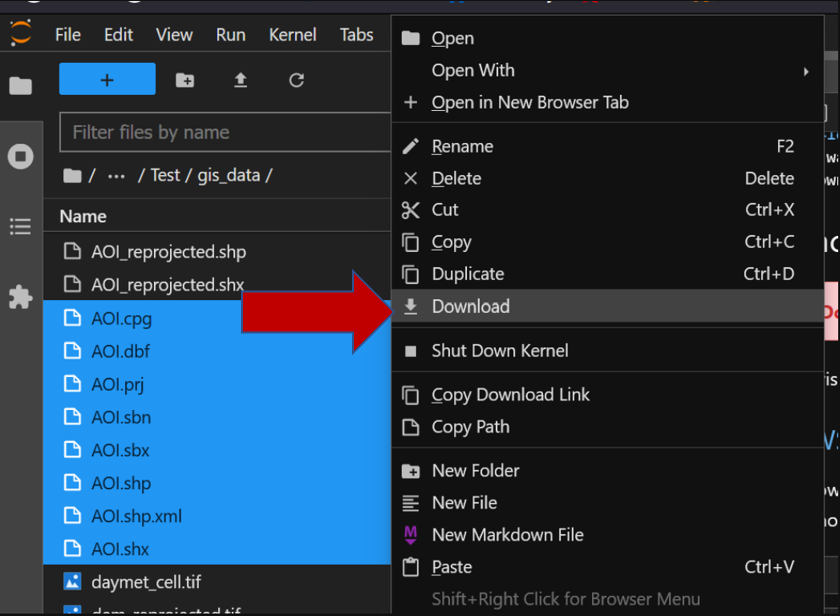

#### Step 2:
Open [The Web Soil Survey](https://websoilsurvey.sc.egov.usda.gov/App/WebSoilSurvey.aspx) and navigate to the AOI from shapefile option

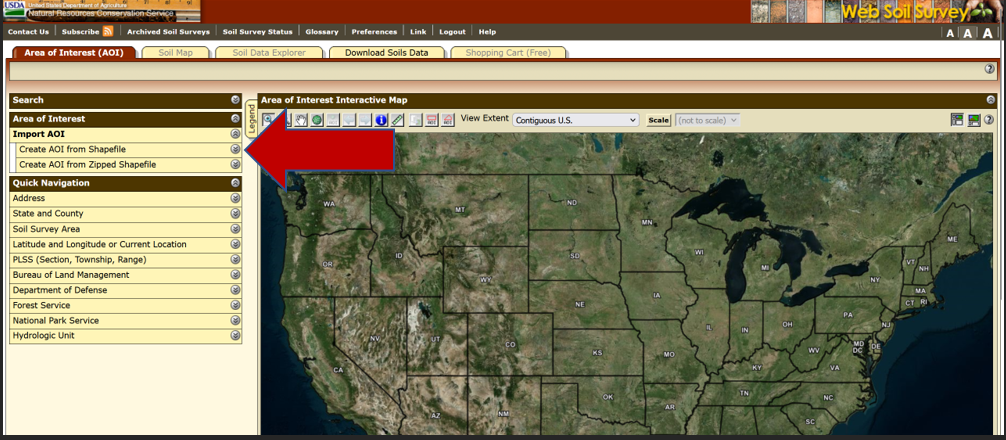

#### Step 3:
Upload required files and then "Set AOI"

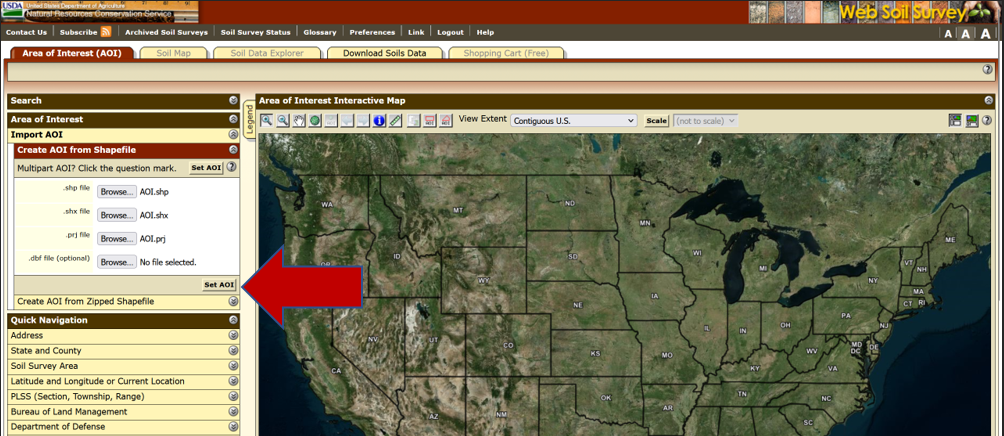

#### Step 4:
Your AOI should now show up and be displayed on the map. Navigate to "Download Soils Data"

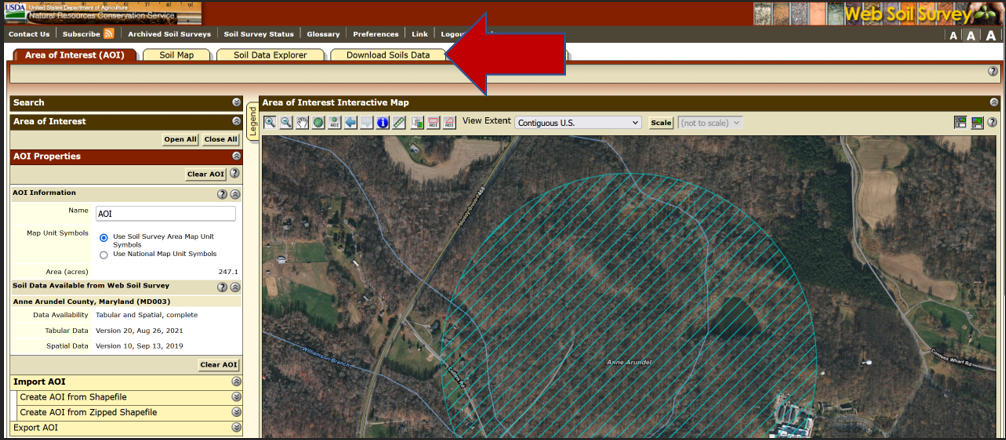

#### Step 5:
Under "Your AOI", select "Create Download Link"

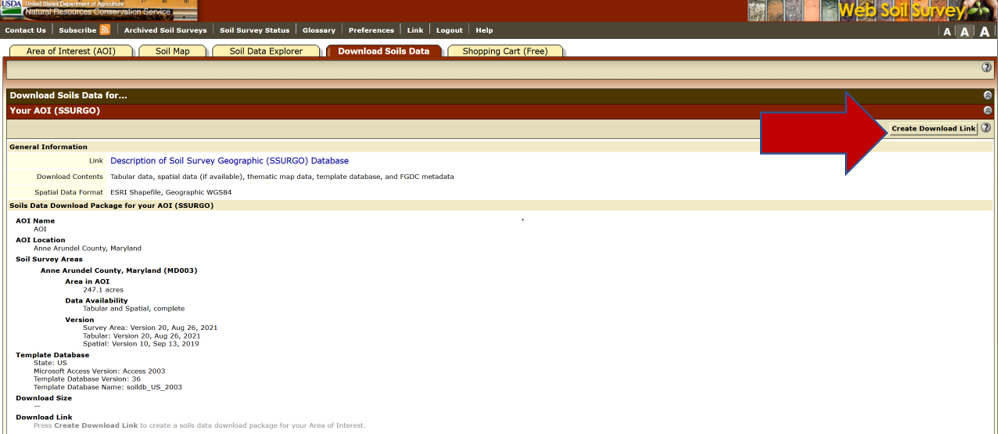

#### Step 6:
The download link should now show up at the bottom of the page. Click it to download to your local drive.

#### Step 7:
Within your JupyterLab session, upload the zipped soil data to your gis_data folder. Rename it to "soil", then run the cell below. Once the data is extracted, rename unzipped folder to "soil" again.

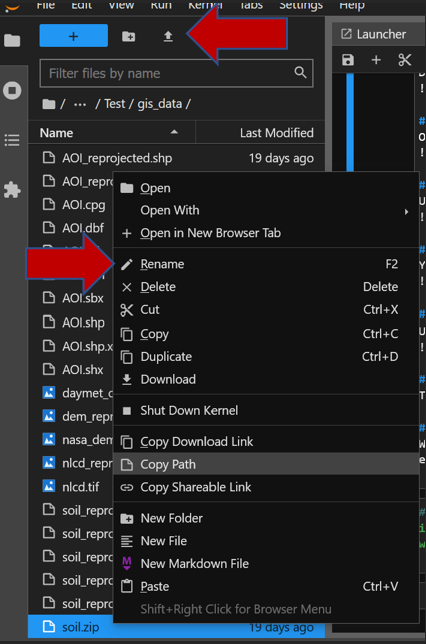

In [14]:
# Extract zipped file of spatial and tabular soil data
import zipfile
with zipfile.ZipFile(os.path.join(RAWGIS_DIR, 'soil.zip'), 'r') as zip_ref:
    zip_ref.extractall(RAWGIS_DIR)